In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import sklearn as sk
import os
from skimage.util import random_noise
import matplotlib.pyplot as plt
from yellowbrick.base import Visualizer
from yellowbrick.cluster import KElbowVisualizer
from PIL import Image, UnidentifiedImageError
from sklearn.cluster import KMeans
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
def normalizeDataSet(dataset):
    dataset = dataset.astype("float32") / 255.0
    return dataset

def createNoiseData(dataset):
    dataset_noise = random_noise(dataset, seed=32)
    return dataset_noise

def readDataSet(input_path="", use_available_dataset=False, val_factor=0.2):
    if use_available_dataset == True:
        (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
        x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
        x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
        raw_data = np.concatenate((x_train, x_test), axis=0)
        ground_truth = np.concatenate((y_train, y_test), axis=0)
    else:
        if os.path.exists(input_path) == False:
            print("Cannot find path.")
            return
        for root, _, files in os.walk(input_path):
            for name in files:
                path = os.path.join(root, name)
                try:
                    Image.open(path)
                except UnidentifiedImageError:
                    print("Corrupt image found in " + path + " , removing...")
                    os.remove(path)
                except:
                    print("Removing non-image file at " + path)
                    os.remove(path)
        dataset = tf.keras.preprocessing.image_dataset_from_directory(
            input_path,
            image_size=(28, 28),
            seed=32
        )
        raw_data = np.array([list(x[0].numpy()) for x in list(dataset.unbatch())])
        ground_truth = np.array([x[1].numpy() for x in list(dataset.unbatch())])
        val_size = int(len(raw_data) * (1 - val_factor))
        raw_data = raw_data.astype("float32") / 255.0
        (x_train, x_test) = (raw_data[0:val_size], raw_data[val_size:len(raw_data)])
    return (raw_data, ground_truth), (x_train, x_test)

In [3]:
(raw_data, ground_truth), (x_train, x_test) = readDataSet(use_available_dataset=True)
print(np.shape(raw_data))

(70000, 28, 28, 1)


In [4]:
def buildAndTrainModel(x_train, x_test, denoising=False):
    _, _, _, num_channels = np.shape(x_train)
    (x_train, x_test) = (normalizeDataSet(x_train), normalizeDataSet(x_test))
    
    input_layer = tf.keras.Input((28, 28, num_channels))
    conv1 = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu")(input_layer)
    norm1 = tf.keras.layers.BatchNormalization()(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(padding="same")(norm1)
    conv2 = tf.keras.layers.Conv2D(64, 5, padding="same", activation="relu")(pool1)
    norm2 = tf.keras.layers.BatchNormalization()(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(padding="same")(norm2)
    conv3 = tf.keras.layers.Conv2D(128, 7, padding="same", activation="relu")(pool2)
    norm3 = tf.keras.layers.BatchNormalization()(conv3)
    pool3 = tf.keras.layers.MaxPooling2D((7, 7), padding="same")(norm3)
    flat_layer = tf.keras.layers.Flatten()(pool3)
    dense_layer = tf.keras.layers.Dense(10)(flat_layer)

    encoder = tf.keras.Model(input_layer, flat_layer, name="encoder")

    decode_layer = tf.keras.layers.Dense((1 * 1 * 128), activation="relu")(dense_layer)
    reshape_layer = tf.keras.layers.Reshape((1, 1, 128))(decode_layer)
    convt1 = tf.keras.layers.Conv2DTranspose(128, 7, strides=7, activation="relu")(reshape_layer)
    convt2 = tf.keras.layers.Conv2DTranspose(64, 5, strides=2, padding="same", activation="relu")(convt1)
    convt3 = tf.keras.layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(convt2)
    decoded = tf.keras.layers.Conv2DTranspose(num_channels, 3, padding="same", activation="sigmoid")(convt3)

    autoencoder = tf.keras.Model(input_layer, decoded, name="autoencoder")
    autoencoder.summary()

    autoencoder.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
    es = EarlyStopping(restore_best_weights=True, patience=1)
    if denoising == True:
        (x_train_noise, x_test_noise) = (createNoiseData(x_train), createNoiseData(x_test))
        autoencoder.fit(x_train_noise, x_train, epochs=1000, batch_size=32, validation_data=(x_test_noise, x_test), callbacks=[es])
        return autoencoder
    autoencoder.fit(x_train, x_train, epochs=1000, batch_size=32, validation_data=(x_test, x_test), callbacks=[es])
    return encoder

In [5]:
encoder = buildAndTrainModel(x_train, x_test)
g_features = encoder.predict(raw_data)
print(np.shape(g_features))

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          

In [6]:
reduced_features = sk.manifold.TSNE().fit_transform(g_features)
print(np.shape(reduced_features))

(70000, 2)


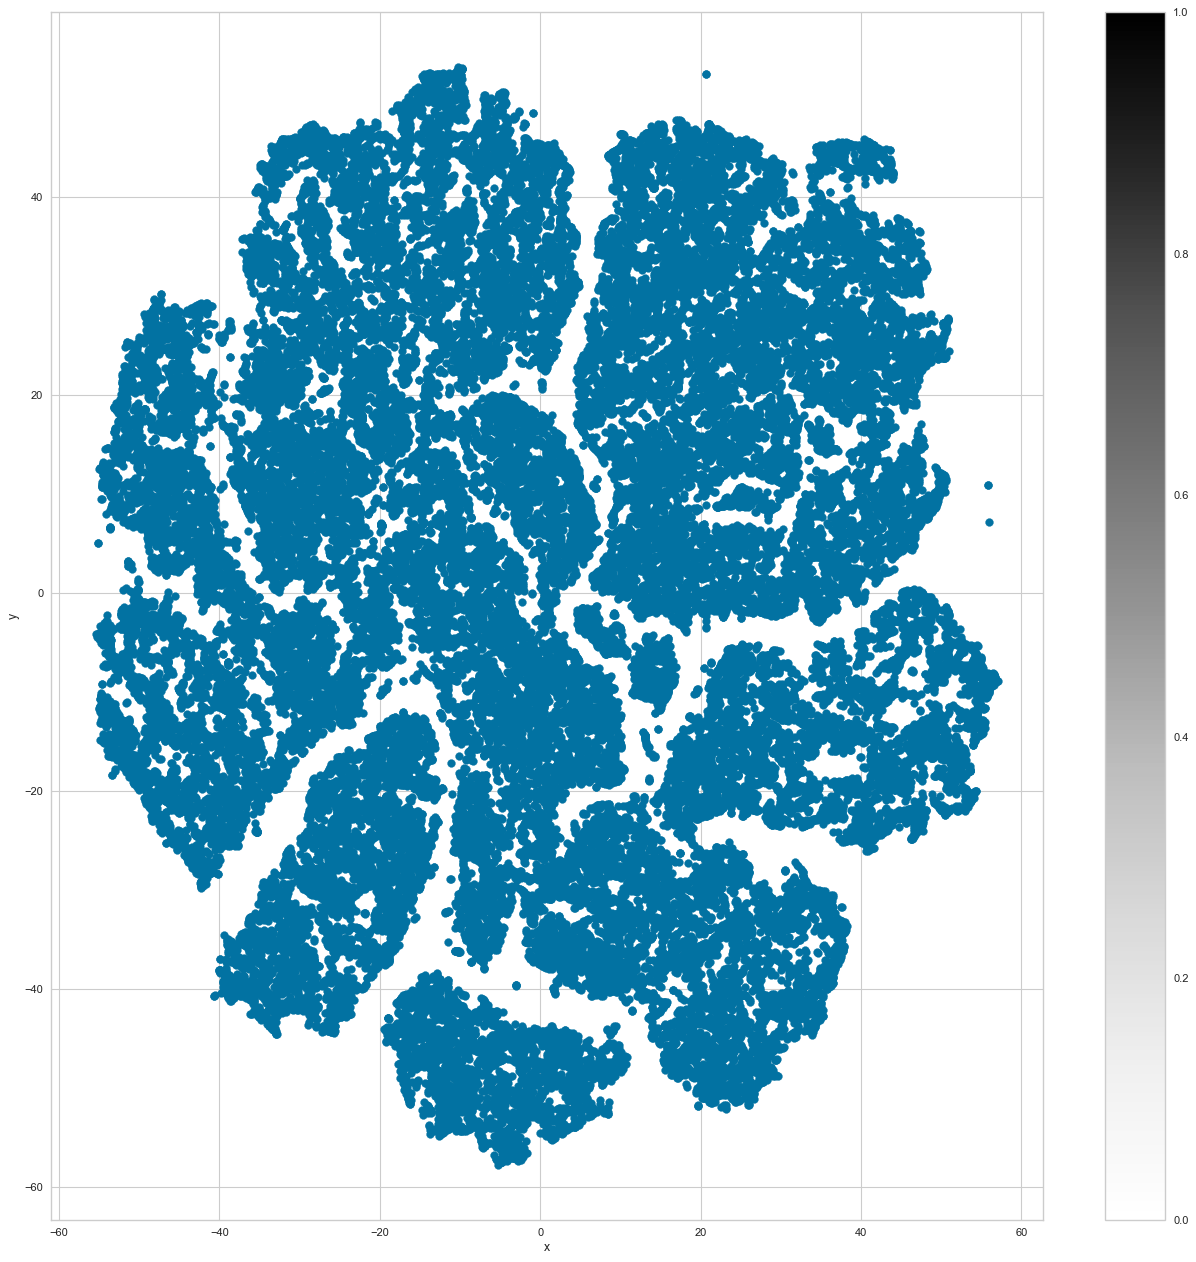

In [7]:
fig = plt.figure(figsize=(20.0, 20.0), dpi=80)
ax = fig.add_subplot(111)
scatter = ax.scatter(reduced_features[:, 0], reduced_features[:, 1], s=50)
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.colorbar(scatter)
plt.show()